In [1]:
import numpy as np
from numpy import pi, diff, random, inf
from astropy.io import fits
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
from scipy import signal, optimize
from skimage.io import imread
from sklearn.cluster import KMeans


from ipywidgets import interact, interactive, fixed, interact_manual, Layout, IntSlider
import ipywidgets as widgets

In C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor 

In [2]:
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [3]:
image_data = np.load('C:/Users/shba3443/Desktop/neural_a2/Sunrise/McClure/doppler data/IMAX_Doppler_extended_obs.npy')
size_image = np.shape(image_data)

tY = signal.tukey(np.shape(image_data)[1],alpha=.1)
tX = signal.tukey(np.shape(image_data)[2],alpha=.1)
tuk2d = np.sqrt(np.outer(tY,tX))
    
arr = []
for n in image_data:
    arr.append((n)*tuk2d)
    
arr = np.array(arr)
f = np.fft.fft(np.fft.fft(arr,axis=2),axis=1)
image_fft = np.fft.fftshift(np.fft.fft(f,axis=0))

In [4]:
def radius(x_coord,y_coord):
    return np.sqrt(x_coord**2 + y_coord**2)

In [5]:
kmPix = 42
sCad = 33

dim_uy   = np.shape(image_data)
nx_uy    = np.fft.fftshift(np.fft.fftfreq(np.shape(image_data)[1], d=kmPix))
ny_uy    = np.fft.fftshift(np.fft.fftfreq(np.shape(image_data)[2], d=kmPix))
omega_uy = np.fft.fftshift(np.fft.fftfreq(np.shape(image_data)[0], d=sCad))

xv, yv = np.meshgrid(nx_uy, ny_uy)
radius_uy = radius(xv,yv)
rad_range = np.linspace(np.min(radius_uy),np.max(radius_uy),int(np.shape(radius_uy)[0]/4))

del_omega = omega_uy[1] - omega_uy[0]
del_rad   = rad_range[1] - rad_range[0]

In [6]:
rad_kw    = np.zeros((np.shape(image_fft)[0],np.shape(rad_range)[0]-1))        
for i_time in range (np.shape(image_fft)[0]):
    for i_rad in range (np.shape(rad_range)[0]-1):
        j,k = np.where((radius_uy > rad_range[i_rad]) & (radius_uy < rad_range[i_rad+1]))
        rad_kw[i_time,i_rad]   = np.mean(np.abs(image_fft[i_time,j,k]))
        
log_rad_kw = np.log10(rad_kw[int(np.shape(image_data)[0]/2):int(np.shape(image_data)[0]/2) + int(np.shape(image_data)[0]/4),:int(np.shape(rad_kw)[1]/4)])

Text(0, 0.5, 'Frequency ($\\mathregular{mHz}$)')

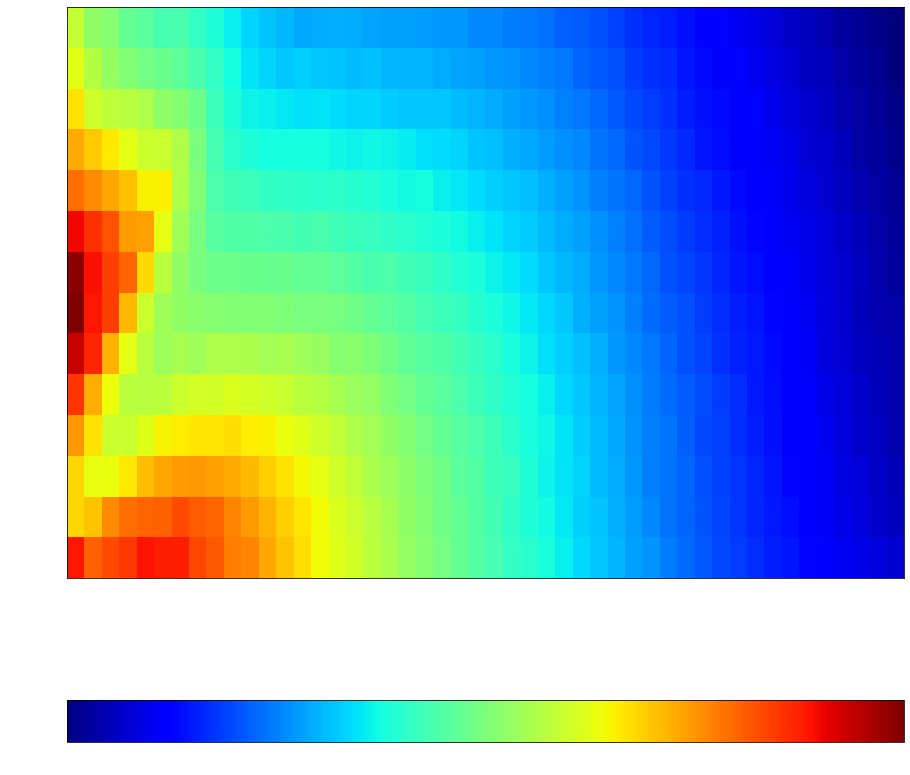

In [7]:
fig = plt.figure(figsize=(15,15))
plt.imshow(log_rad_kw,aspect='auto',cmap = 'jet',origin = 'lower', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega_uy)*1000])
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{Mm^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)

In [8]:
plt.imsave('test_9_7_2021.png', log_rad_kw, cmap=plt.cm.jet)

In [9]:
def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
    return df

Text(0, 0.5, 'Frequency ($\\mathregular{mHz}$)')

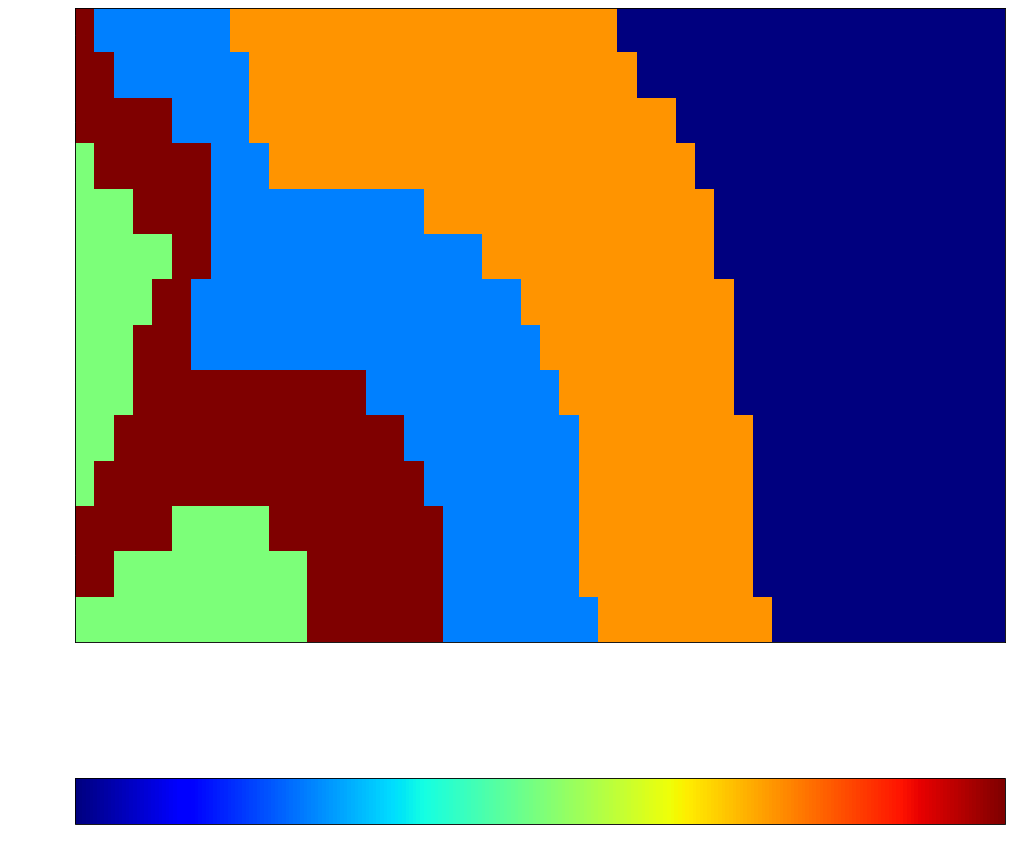

In [10]:
island = imread('test_9_7_2021.png')
df_island = image_to_pandas(island)

kmeans = KMeans(n_clusters=  5, random_state = 42).fit(df_island)
result = kmeans.labels_.reshape(island.shape[0],island.shape[1])
plt.figure(figsize=(15, 15), dpi=80)
plt.imshow(result, aspect='auto', cmap = 'jet', origin = 'lower', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega_uy)*1000]);
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{Mm^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)

In [11]:
result[result == 2] = 10
result[result < 5]  = 0

ii = np.where(result == 10)
x0 = ii[0]
y0 = ii[1]

In [12]:
def f(m):
    d = np.abs((m)*x0-y0)/np.sqrt((m)**2+1)
    return np.std(d)

In [13]:
minimum = optimize.fmin(f, x0=0)
slope = minimum[0]
print(slope)

Optimization terminated successfully.
         Current function value: 1.783790
         Iterations: 25
         Function evaluations: 50
1.116750000000001


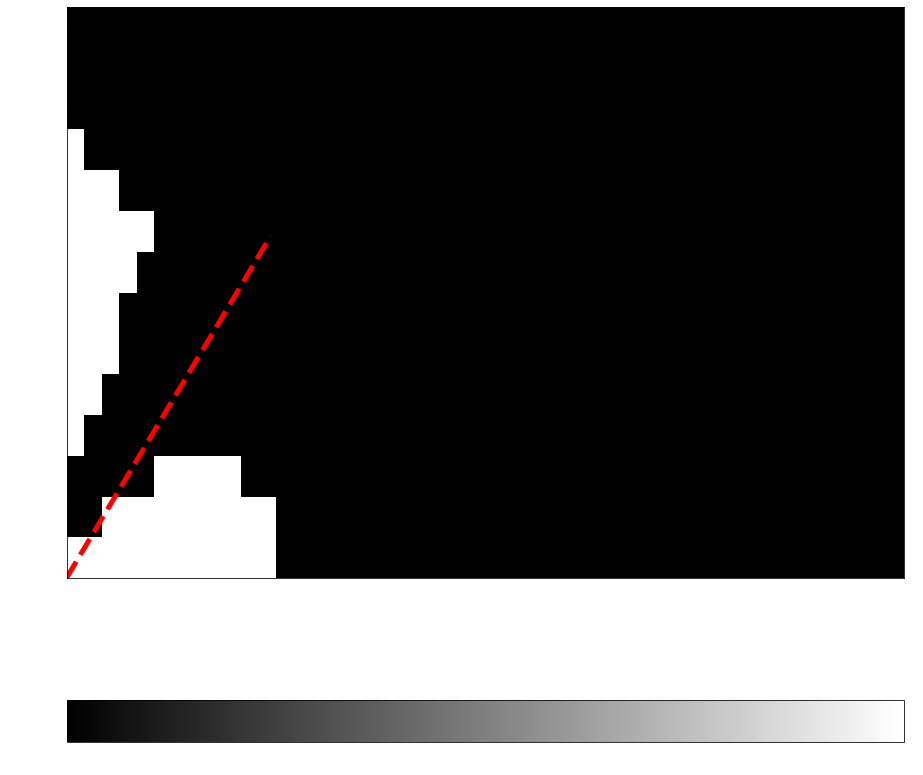

In [14]:
xline_for_slope = rad_range[:int(np.shape(rad_range)[0]/4)]
yline_for_slope = (slope*xline_for_slope)/del_omega
plt.figure(figsize=(15, 15))
plt.imshow(result, aspect='auto',origin = 'lower',cmap = 'gray', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega_uy)*1000]);
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{Mm^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)
plt.plot(xline_for_slope, yline_for_slope, '--r', linewidth = 5)

In [15]:
filter_speed = slope*del_omega/del_rad

kw_speed = np.zeros_like(image_fft)
for i in range (np.shape(kw_speed)[0]):
    kw_speed[i,:,:] = np.abs(omega_uy[i]/radius_uy[:,:])

C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [17]:
f_gran = np.copy(image_fft)
f_mode = np.copy(image_fft)

i,j,k = np.where(np.real(kw_speed) < filter_speed)
f_mode[i,j,k] = 0
mode = np.fft.ifftn(np.fft.ifftshift(f_mode))
filtered_mode = np.real(mode)

i,j,k = np.where(np.real(kw_speed) > filter_speed)
f_gran[i,j,k] = 0
gran = np.fft.ifftn(np.fft.ifftshift(f_gran))
filtered_gran = np.real(gran)

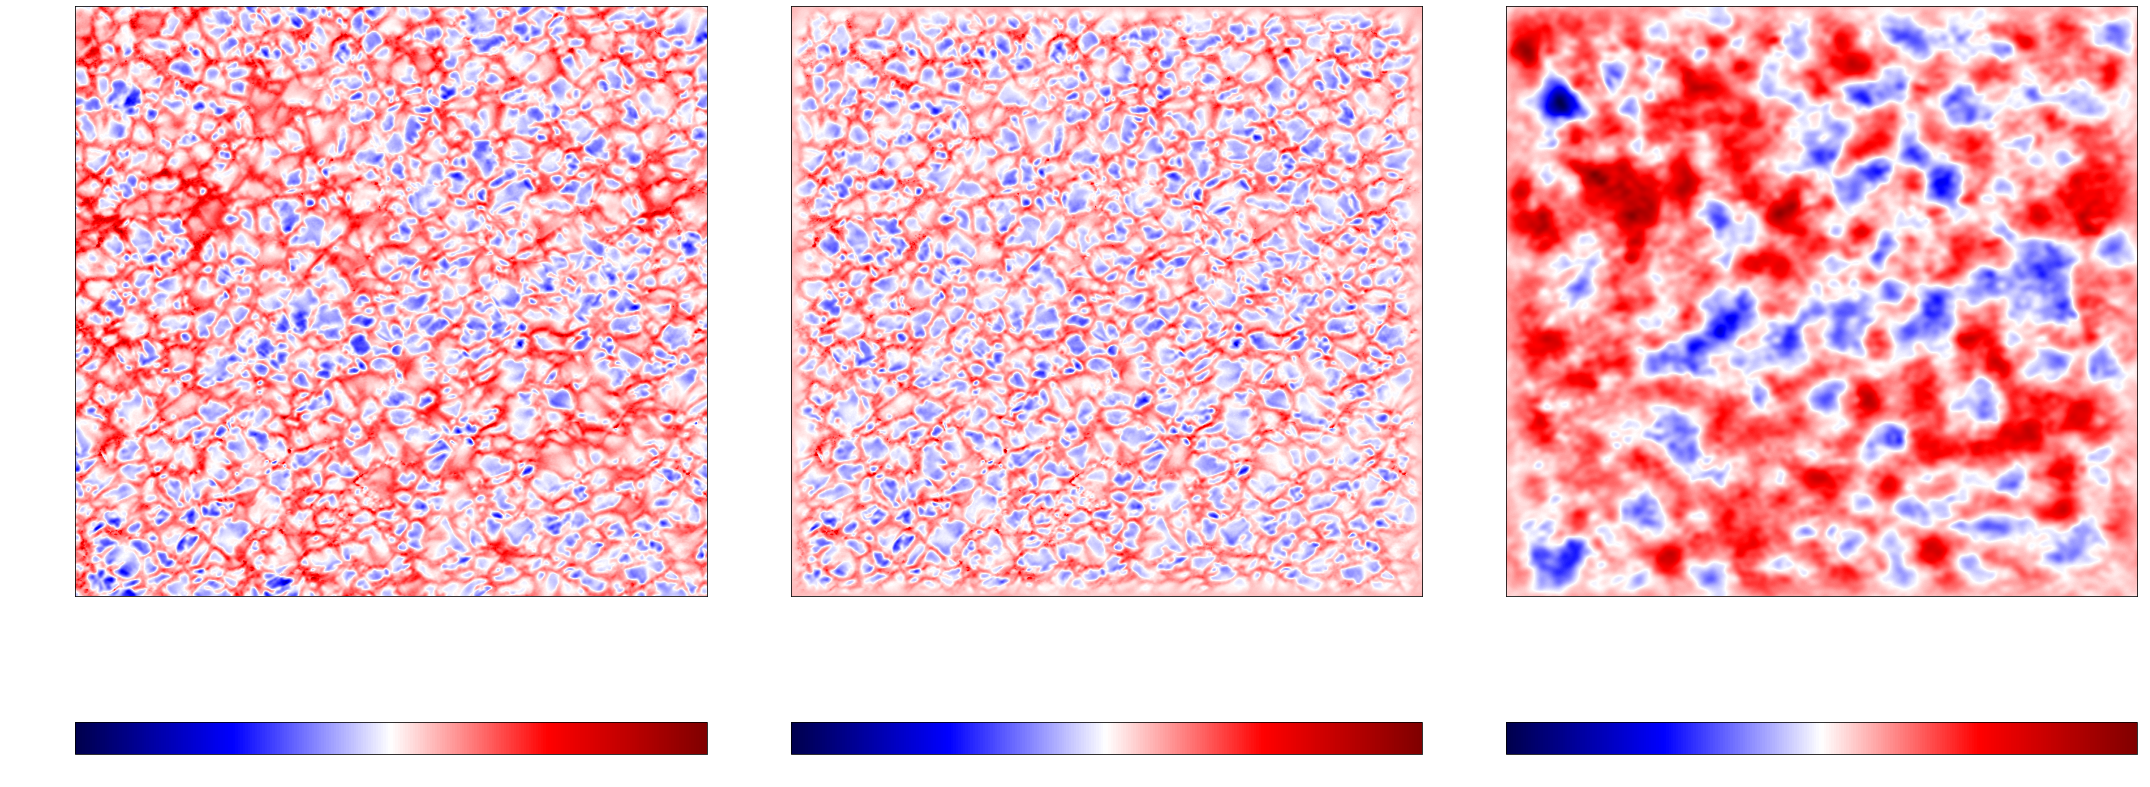

In [18]:
plt.figure(figsize=(30, 12))
plt.subplot(1, 3, 1)
plt.imshow(image_data[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=20)

plt.subplot(1, 3, 2)
plt.imshow(filtered_gran[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=20)

plt.subplot(1, 3, 3)
plt.imshow(filtered_mode[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=20)

plt.tight_layout()